# Trabajo Final procesamiento de lenguaje natural (NLP) <a class="tocSkip">
## Universidad Pontificia Bolivariana <a class="tocSkip">

**Estudiante:** William Esteban Mora Quigua

**ID:** 000355839



**Subir Este notebook de Trabajo Final en su repositorio de GitHub. y enviar el link en **Microsoft TEAMS**

Docente: [Jose R. Zapata](https://joserzapata.github.io)
- https://joserzapata.github.io
- https://www.linkedin.com/in/jose-ricardo-zapata-gonzalez/       


## Objetivo del Trabajo
Realizar un proceso de Procesamiento de lenguaje natural (NLP) para dejar los datos preparados para ser usados con algoritmos de Machine Learning para Clasificación como objetivo final del trabajo.

los datos preparados para ser usados con algoritmos de Machine Learning para Regresión o Clasificación como objetivo final del trabajo.

El trabajo se realizara en este jupyter notebook y subirlo a su repositorio de github creado en clase. (**Recuerde poner su nombre e información**)

## Las actividades a realizar
    

1) Limpiar los datos de texto.

   - https://joserzapata.github.io/courses/nlp/procesamiento-basico/

   - https://joserzapata.github.io/courses/nlp/preprocesamiento-texto/

2) Realizar la representación de texto:

   - https://joserzapata.github.io/courses/nlp/representaciones/

   - Tokenización
   - Lematización o stemming
   - Representación de los datos de texto (Bag of Words o TF-IDF)

3) Utilice un modelo de Machine Learning para clasificación para entrenar y evaluar el modelo.
        
    - Calcule estas las métricas de evaluación (accuracy, precision, recall, f1-score) - https://joserzapata.github.io/courses/python-ciencia-datos/clasificacion/#evaluacion-modelo-simple


    
   
    
*NOTA: No dude en contactarme para cualquier pregunta o inquietud :) por el chat de Teams o al correo
joser.zapata@upb.edu.co*

## EVALUACIÓN


|Porcentaje en la evaluación | Descripción| Nada | Incompleto | Completo 
| :---: |:---: |:---: |:---: |:---: 
| 5 % |**limpieza de los datos** |
| 5 % | **Representacion de los datos** |
| 5 % | **Machine Learning** <br> Entrenar y evaluar el modelo propuesto |


In [6]:
import pandas as pd

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
)
from sklearn.model_selection import train_test_split

Carga del dataset

El archivo  se carga en aproximadamente 10 segundos

In [7]:
# Usar su ID UPB Ejemplo: "0028984798"
id_upb = "000355839"

data_reviews = pd.read_parquet(
    "https://www.dropbox.com/scl/fi/gvk9yj8cn96oocr9z058x/filmaffinity_reviews_dataset.parquet?rlkey=xgvr00zvkxbkwqqavqutpsshg&st=xjb7xze9&dl=1"
)
data_reviews = data_reviews.sample(n=50_000, random_state=int(id_upb))
data_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50000 entries, 71185 to 98710
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   author_review_desc  50000 non-null  string
 1   author_rating       50000 non-null  int64 
dtypes: int64(1), string(1)
memory usage: 1.1 MB


Ejemplo de algunas filas del dataset

In [8]:
data_reviews.sample(5)

,author_review_desc,author_rating
17909,"\nEn primer lugar, merece la pena cada segundo...",10
89146,"\nEl absurdo es iraní, ni Kafka ni Ionesco ni ...",1
135572,\nPor: John Harold Giraldo Herrera\n\n\nEl esp...,5
100053,\nEsta película (que en realidad iba a ser una...,7
2105,\nPelícula pésima: falla en todos los sentidos...,2


Evaluar los valores nulos

In [9]:
data_reviews.isnull().sum()

author_review_desc    0
author_rating         0
dtype: int64

En este caso no hay nulos.

Revisar si hay valores duplicados:

In [10]:
data_reviews.duplicated().sum()

np.int64(3)

Se hace una limpieza de todo antes 

In [13]:
import re
import unicodedata


def limpiar_texto(texto):
    if pd.isnull(texto):
        return ""

    texto = texto.lower()  # minúsculas
    texto = re.sub(r"\s+", " ", texto)  # eliminar espacios múltiples y saltos de línea
    texto = re.sub(r"http\S+|www\S+", "", texto)  # eliminar URLs
    texto = re.sub(r"[^a-záéíóúüñ0-9\s]", "", texto)  # mantener letras y números
    texto = "".join(  # quitar tildes
        c
        for c in unicodedata.normalize("NFD", texto)
        if unicodedata.category(c) != "Mn"
    )
    return texto.strip()


# --- Aplicar limpieza ---
data_reviews["texto_limpio"] = data_reviews["author_review_desc"].apply(limpiar_texto)

# --- Eliminar duplicados y reseñas vacías o muy cortas ---
data_reviews = data_reviews.drop_duplicates(subset="texto_limpio")
data_reviews = data_reviews[data_reviews["texto_limpio"].str.split().str.len() > 5]

# --- Ver resultados ---
data_reviews[["author_review_desc", "texto_limpio"]].head()


,author_review_desc,texto_limpio
71185,\nCon un impresionante guión de William Goldma...,con un impresionante guion de william goldman ...
53362,\nEsto es una comedia y no las americanadas qu...,esto es una comedia y no las americanadas que ...
102663,\nLenguaje ascético para una película notable ...,lenguaje ascetico para una pelicula notable he...
111226,"\nEs toda una sorpresa, cuando vas a poner una...",es toda una sorpresa cuando vas a poner una pe...
22315,\nGuión muy repetido pero un film que consigue...,guion muy repetido pero un film que consigue e...


No hay  valores duplicados.

## Clasificación Tradicional para Análisis de Sentimientos y Categorías 👍 👎



Definición: Se considera reseña positiva cuando la puntuación ("author_rating") es mayor que 6; negativa en caso contrario.

Crear la variable binaria de sentimiento: 1 (positivo) si author_rating > 6, 0 (negativo) de lo contrario

In [14]:
UMBRAL = 6
data_reviews["sentiment_bin"] = (data_reviews["author_rating"] > UMBRAL).astype(int)

In [15]:
# Dividir los datos en conjuntos de entrenamiento y prueba

#X_data = data_reviews["author_review_desc"] se pone mejor el texto limpio
X_data = data_reviews["texto_limpio"]
y_data = data_reviews["sentiment_bin"]


Dividir el dataset en entrenamiento y prueba

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X_data,
    y_data,
    test_size=0.2,
    stratify=y_data,  # Mantener la proporción de clases en ambos conjuntos
    random_state=42,
)

## Análisis exploratorio de los datos

para determinar que tipo de limpieza se debe realizar a los datos de texto de `X_train`

In [17]:
X_train.info()

<class 'pandas.core.series.Series'>
Index: 39991 entries, 144567 to 73037
Series name: texto_limpio
Non-Null Count  Dtype 
--------------  ----- 
39991 non-null  object
dtypes: object(1)
memory usage: 624.9+ KB


In [18]:
X_train.head()

144567    el tiempo del lobo es una pelicula que me ha d...
27351     tras un hecho traumatico que la convierte en h...
50895     mi pecado antes ver esta pelicula fue ver dune...
78492     tiene un claro formato western no tanto por el...
72268     obra maestra del cine en donde presenciamos un...
Name: texto_limpio, dtype: object

In [19]:
X_train.isnull().sum()

np.int64(0)

In [22]:
X_train.isnull().sample(5, random_state=42)

67614     False
53118     False
106064    False
44193     False
108576    False
Name: texto_limpio, dtype: bool

In [23]:
print(f"Cantidad de reseñas de entrenamiento: {len(X_train)}")
X_train.head(10)


Cantidad de reseñas de entrenamiento: 39991


144567    el tiempo del lobo es una pelicula que me ha d...
27351     tras un hecho traumatico que la convierte en h...
50895     mi pecado antes ver esta pelicula fue ver dune...
78492     tiene un claro formato western no tanto por el...
72268     obra maestra del cine en donde presenciamos un...
58539     narra la historia de amor y desamor entre pris...
17196     vayamos por partes a desde que disney comprara...
6800      entretenida pelicula que abusa del recurso de ...
5485      sera que hay cosas que con el paso del tiempo ...
109180    en un panorama donde muchas series buscan ser ...
Name: texto_limpio, dtype: object

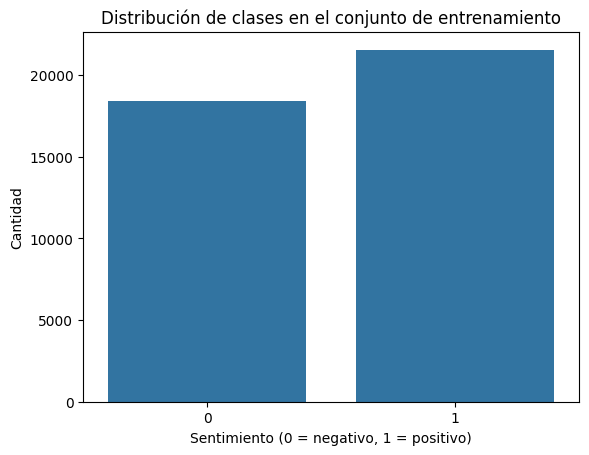

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x=y_train)
plt.title("Distribución de clases en el conjunto de entrenamiento")
plt.xlabel("Sentimiento (0 = negativo, 1 = positivo)")
plt.ylabel("Cantidad")
plt.show()


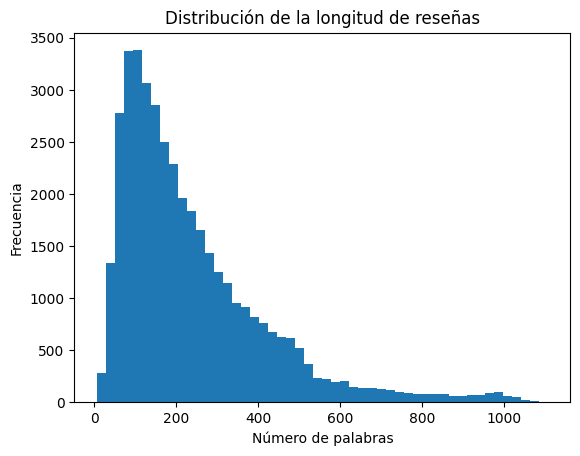

Longitud media de las reseñas: 237.4907354154685
Longitud mínima: 6
Longitud máxima: 1106


In [26]:
X_train_length = X_train.apply(lambda x: len(str(x).split()))
plt.hist(X_train_length, bins=50)
plt.title("Distribución de la longitud de reseñas")
plt.xlabel("Número de palabras")
plt.ylabel("Frecuencia")
plt.show()

print("Longitud media de las reseñas:", X_train_length.mean())
print("Longitud mínima:", X_train_length.min())
print("Longitud máxima:", X_train_length.max())


## 1) Limpieza de los datos de texto

Tomar los datos de `X_train` y aplicar las funciones de limpieza que considere necesarias

Ayudas:

- Convertir a minúsculas
- Eliminar caracteres especiales y números
- Corregir palabras mal escritas
- etc


Se limpio anteriormente

## 2) Representacion del texto

Luego de tener los datos limpios, realizar la representación de los datos de texto para poder usarse en modelos de machine learning.

In [27]:
import nltk
from nltk.corpus import stopwords

# Descargar las stopwords en español (solo la primera vez)
nltk.download("stopwords")

# Cargar las stopwords en español
spanish_stopwords = stopwords.words("spanish")


[nltk_data] Downloading package stopwords to /home/vscode/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [28]:
####vectorizar las palabras
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    max_features=5000, ngram_range=(1, 2), stop_words=spanish_stopwords
)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print(f"Shape de X_train_tfidf: {X_train_tfidf.shape}")
print(f"Shape de X_test_tfidf: {X_test_tfidf.shape}")


Shape de X_train_tfidf: (39991, 5000)
Shape de X_test_tfidf: (9998, 5000)


## 3) Entrenar un modelo de machine learning de clasificación

Utilizar un modelo de clasificación para entrenar y evaluar el modelo con los datos preparados.


🔹 Exactitud (Accuracy): 0.8034606921384276

🔹 Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.80      0.77      0.78      4608
           1       0.81      0.83      0.82      5390

    accuracy                           0.80      9998
   macro avg       0.80      0.80      0.80      9998
weighted avg       0.80      0.80      0.80      9998



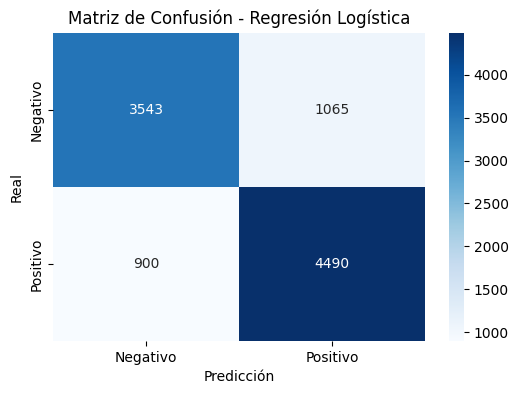

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Entrenar modelo de Regresión Logística
modelo = LogisticRegression(max_iter=1000, random_state=42)
modelo.fit(X_train_tfidf, y_train)

# Predecir en el conjunto de prueba
y_pred = modelo.predict(X_test_tfidf)

# Métricas
print("🔹 Exactitud (Accuracy):", accuracy_score(y_test, y_pred))
print("\n🔹 Reporte de Clasificación:")
print(classification_report(y_test, y_pred))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Negativo", "Positivo"],
    yticklabels=["Negativo", "Positivo"],
)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - Regresión Logística")
plt.show()


### Evaluar el modelo con los datos de prueba

Usar el modelo para predecir en `X_test` y evaluar con `y_test`

**Nota:** Recuerde que `X_test` debe pasar por los mismos procesos de limpieza y representación que `X_train`

In [30]:
# Transformar los datos de prueba usando el mismo vectorizador
X_test_tfidf = vectorizer.transform(X_test)


🔹 Exactitud (Accuracy): 0.8034606921384276

🔹 Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.80      0.77      0.78      4608
           1       0.81      0.83      0.82      5390

    accuracy                           0.80      9998
   macro avg       0.80      0.80      0.80      9998
weighted avg       0.80      0.80      0.80      9998



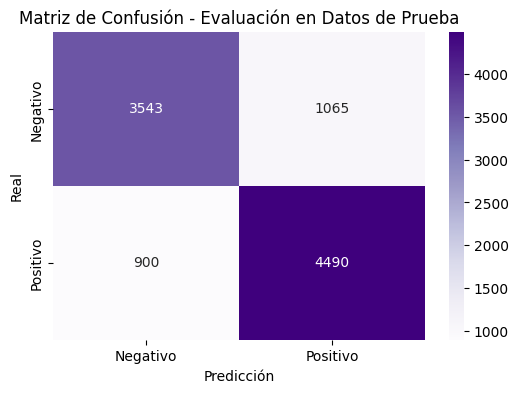

In [31]:
# Predicciones en el conjunto de prueba
y_pred = modelo.predict(X_test_tfidf)


print("🔹 Exactitud (Accuracy):", accuracy_score(y_test, y_pred))
print("\n🔹 Reporte de Clasificación:")
print(classification_report(y_test, y_pred))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Purples",
    xticklabels=["Negativo", "Positivo"],
    yticklabels=["Negativo", "Positivo"],
)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - Evaluación en Datos de Prueba")
plt.show()


In [32]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred))
print("Reporte de clasificación:\n", classification_report(y_test, y_pred))

Accuracy: 0.8034606921384276
Precision: 0.8082808280828083
Recall: 0.8330241187384044
F1 Score: 0.8204659661946094
ROC AUC Score: 0.8009521635358688
Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.80      0.77      0.78      4608
           1       0.81      0.83      0.82      5390

    accuracy                           0.80      9998
   macro avg       0.80      0.80      0.80      9998
weighted avg       0.80      0.80      0.80      9998



**Guardar el modelo**

In [33]:
import joblib

## Librerías Usadas

In [36]:
from watermark import watermark

print(watermark(python=True, iversions=True, globals_=globals()))

Python implementation: CPython
Python version       : 3.12.11
IPython version      : 9.6.0

nltk      : 3.9.2
matplotlib: 3.10.7
joblib    : 1.5.2
pandas    : 2.3.3
seaborn   : 0.13.2
sklearn   : 1.7.2
watermark : 2.5.0
re        : 2.2.1



---

## Referencias
- [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)
- [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)
- [Classification of text documents using sparse features](https://scikit-learn.org/stable/auto_examples/text/plot_document_classification_20newsgroups.html)
- Ejemplo de Entrenamiento y selección de Modelo de machine learning entre varios modelos <https://joserzapata.github.io/post/ciencia-datos-proyecto-python/6-model_selection/>
- https://joserzapata.github.io/courses/python-ciencia-datos/python/
- https://joserzapata.github.io/courses/python-ciencia-datos/pandas/
- https://joserzapata.github.io/courses/python-ciencia-datos/machine-learning/

Docente: [Jose R. Zapata](https://joserzapata.github.io)

- [https://joserzapata.github.io/](https://joserzapata.github.io/)
- [https://www.linkedin.com/in/jose-ricardo-zapata-gonzalez/](https://www.linkedin.com/in/jose-ricardo-zapata-gonzalez/)